## Using Hankel Transformation to extract the radial feature from the images


In [2]:
# All the standard packages required in this notebook

import os
import numpy as np
import pandas as pd
import cv2
from scipy.special import j0
from scipy.special import jv
from scipy.integrate import quad
from scipy.integrate import simpson as simps
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

# To import the required functions
sys.path.append(os.path.abspath(os.path.join("..", "src")))

### Implementing the hankel transform directly on the images

In [ ]:
# Function to apply Hankel Transform on a 2D image
def hankel_transform(image, order=0, k_values=np.linspace(0, 50, 100)):
    height, width = image.shape
    y, x = np.indices((height, width))
    center = (height // 2, width // 2)
    
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    f_r = image
    
    # Hankel Transform computation
    def integrand(r, k):
        return f_r[int(r), int(r)] * jv(order, k * r) * r
    
    hankel_result = np.zeros_like(k_values)
    for i, k in enumerate(k_values):
        hankel_result[i], _ = quad(integrand, 0, min(center), args=(k,))
    
    return hankel_result

# Load an MRI image
image_path = "../dataset/processed_dataset/positive/1.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = img / 255.0   # Normalizing the pixels

# Apply Hankel Transform
hankel_features = hankel_transform(img)

print("Hankel Transform Features Extracted:", hankel_features)

C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16916\3019013183.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  hankel_result[i], _ = quad(integrand, 0, min(center), args=(k,))
C:\Users\Shreyash\AppData\Local\Temp\ipykernel_16916\3019013183.py:16: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  hankel_result[i], _ = quad(integrand, 0, min(center), args=(k,))


Hankel Transform Features Extracted: [ 6.70202467e+03 -1.75821541e+01  4.56239386e+00 -2.89391003e+00
  2.41212599e+00 -9.43315906e-01  4.02914552e-01 -2.83511908e-01
 -2.25863981e-01  2.35807440e-01 -3.75717748e-01  5.15039533e-01
 -3.71404944e-01 -1.30173004e-01  1.27569046e+01 -2.15023476e-01
  1.91276871e-01 -2.54417857e-01  3.90313997e-01 -4.18977916e-01
  2.52120981e-01  1.73955577e+01 -3.13511218e+00  2.43418714e+00
  4.72524539e-01  1.44238004e+00  8.25728583e-01 -7.02838265e-01
  1.83489093e+00 -3.46236433e-01  2.66547638e+00 -6.48826836e-01
  3.16785068e-01 -2.86984389e-01  3.69072661e-02  3.70092021e+00
  2.74849035e-01 -2.56083903e+00  1.28927685e+00  1.28922617e-01
 -1.00141174e+00  6.64676469e-01  9.34502510e+00  2.22672430e+00
  1.26248084e+00 -2.43188140e-01  1.26956566e-01  1.04193235e+00
 -4.33825866e-01 -1.29090378e+00  1.01478453e+00  1.55275907e+00
 -6.60003464e-01 -3.39107831e+00 -3.75382957e-01  9.92333692e-01
  9.83338684e+00 -3.46467225e-01  2.48768623e-01 -2.6

### Converting the images to radial profile and then implementing the Hankel transform

*[Note] This code will take quite much time to execute depending on the processor and available memory.*

In [ ]:
from radial_profile import radial_profile
from hankel_transform import hankel_transform_1d

# Plotting the graphs of Hankel result
def plot_and_save(radial_intensity, hankel_result, k, save_path):
    fig, axs = plt.subplots(2, 1, figsize=(4, 4), dpi=100)  # Smaller figure, lower DPI

    axs[0].plot(radial_intensity, color='purple')
    axs[0].set_title('Radial Intensity Profile')
    axs[0].set_xlabel('Radius')
    axs[0].set_ylabel('Intensity')

    axs[1].plot(k, np.abs(hankel_result), color='green')
    axs[1].set_title('Hankel Transform Magnitude')
    axs[1].set_xlabel('k')
    axs[1].set_ylabel('|Transform|')

    plt.tight_layout()
    fig.savefig(save_path)  # Use fig.savefig for explicit figure saving
    plt.close(fig)  # Properly close the figure to free memory


# Dataset paths
input_base = '../dataset/processed_dataset'
output_base = '../dataset/graphs'

print("Graph creation process started.")
for label in ['positive', 'negative']:
    input_folder = os.path.join(input_base, label)
    output_folder = os.path.join(output_base, label)
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.png')

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to read {image_path}")
            continue

        img = cv2.resize(img, (512, 512)) / 255.0

        radial = radial_profile(img)
        r = np.arange(len(radial))
        k, hankel = hankel_transform_1d(radial, r)

        plot_and_save(radial, hankel, k, output_path)

print("Graph creation process completed.")

### Implementing Hankel transformation by dividing the images in patches

In [3]:
from extract_features import extract_patch_features

✅ Extracted 16 patch feature rows.


patch_x  patch_y    hankel_f_0  hankel_f_1  hankel_f_2  hankel_f_3  \
0        0        0   1879.375780    0.326320    2.157242    7.036595   
1       64        0  22979.566573   99.510462   38.733591  115.450446   
2      128        0  23956.499602  128.313384   32.527496  107.773053   
3      192        0   2063.642417    4.024053    0.166226    8.508663   
4        0       64  19112.738712   63.339168   16.236745   86.734360   

   hankel_f_4  hankel_f_5  hankel_f_6  hankel_f_7  ...  hankel_f_35  \
0    2.535888    1.644423    1.901093    1.728841  ...     0.449827   
1   38.263644  145.884252  104.822890    5.786661  ...     4.520668   
2   36.737298  140.823931   86.845479   21.384516  ...     8.215154   
3    5.873980    3.793777    6.628051    5.271325  ...     0.039686   
4   29.644680  105.582708   99.269617   21.675988  ...     3.258405   

   hankel_f_36  hankel_f_37  hankel_f_38  hankel_f_39  hankel_f_40  \
0     5.410499     0.599859     0.595865     2.413959     0.843652   
1    64.253058    14.841646    34.454428    24.388410     6.608831   
2    63.994388    13.327720    36.914309    24.637241    17.975382   
3     6.176074     1.184534     2.152788     4.575603     2.000707   
4    18.331818     7.774673    21.487577   106.919423     6.071339   

   hankel_f_41  hankel_f_42  hankel_f_43  hankel_f_44  
0     0.766328     0.004321     0.093856     3.734922  
1     1.270105    17.247679     9.012516    31.128018  
2     0.164315    18.699573     1.483589    30.311945  
3     1.430840     0.429866     0.469911     1.205042  
4    12.759259     4.664252     8.277083    30.043643  

[5 rows x 47 columns]

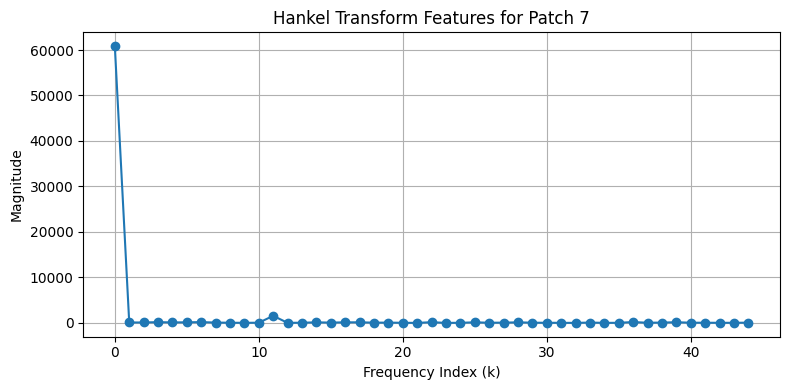

In [4]:
img_path = "../dataset/processed_dataset/positive/1.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))

# Extract features
patch_features = extract_patch_features(img)

# Convert to DataFrame for better display
df = pd.DataFrame(patch_features)

print(f"✅ Extracted {len(df)} patch feature rows.")
display(df.head())

first_patch_features = df.iloc[6][[col for col in df.columns if col.startswith("hankel_f_")]].values

plt.figure(figsize=(8, 4))
plt.plot(first_patch_features, marker='o')
plt.title("Hankel Transform Features for Patch 7")
plt.xlabel("Frequency Index (k)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

### Extracting the simplified features from the images

In [7]:
from extract_simplified_features import extract_patch_features

In [9]:
def process_dataset(label, input_dir, output_dir, size=(256, 256), patch_size=(64, 64)):
    os.makedirs(output_dir, exist_ok=True)
    count = 1

    for fname in tqdm(sorted(os.listdir(input_dir)), desc=f"Processing {label}"):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        img_path = os.path.join(input_dir, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, size)
        features = extract_patch_features(img, patch_size=patch_size)
        df = pd.DataFrame(features)

        csv_file = f"{label}_{count}.csv"
        df.to_csv(os.path.join(output_dir, csv_file), index=False)
        count += 1

base_dir = "../dataset/processed_dataset"
out_dir = "../dataset/extracted_feature"

process_dataset("positive", os.path.join(base_dir, "positive"), os.path.join(out_dir, "positive"))
process_dataset("negative", os.path.join(base_dir, "negative"), os.path.join(out_dir, "negative"))

Processing negative: 100%|██████████| 522/522 [00:26<00:00, 19.73it/s]


#### Collecting the average values from each image's feature file

In [20]:
def collect_average_features(folder_path, output_csv):
    data = []

    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    for file in tqdm(files, desc=f"Processing {os.path.basename(folder_path)}"):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        if not df.empty:
            avg_row = df.iloc[-1].copy()
            avg_row.iloc[0:2] = None  # Remove 'avg', 'avg'
            features = avg_row.dropna().astype(float).to_dict()
            features = {'filename': file, **features}
            data.append(features)

    final_df = pd.DataFrame(data)
    final_df.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv}")

base = "../dataset/extracted_feature"
out = "../dataset/combined_extracted"
os.makedirs(out, exist_ok=True)
collect_average_features(os.path.join(base, "positive"), os.path.join(out, "positive.csv"))
collect_average_features(os.path.join(base, "negative"), os.path.join(out, "negative.csv"))


Processing positive: 100%|██████████| 3956/3956 [00:05<00:00, 720.08it/s]


Saved: ../dataset/combined_extracted\positive.csv


Processing negative: 100%|██████████| 522/522 [00:00<00:00, 660.91it/s]

Saved: ../dataset/combined_extracted\negative.csv


In [21]:
pos_df = pd.read_csv("../dataset/combined_extracted/positive.csv")
neg_df = pd.read_csv("../dataset/combined_extracted/negative.csv")

pos_df['label'] = 1
neg_df['label'] = 0

full_df = pd.concat([pos_df, neg_df], ignore_index=True)

features_df = full_df.drop(columns=[full_df.columns[0]])

correlation = features_df.corr(numeric_only=True)['label'].drop('label').sort_values(key=abs, ascending=False)

top_features = correlation.head(10)

top_features

hankel_skew       -0.116639
hankel_kurtosis   -0.116461
hankel_mean       -0.114057
hankel_peak       -0.112457
hankel_std        -0.112426
Name: label, dtype: float64

In [17]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

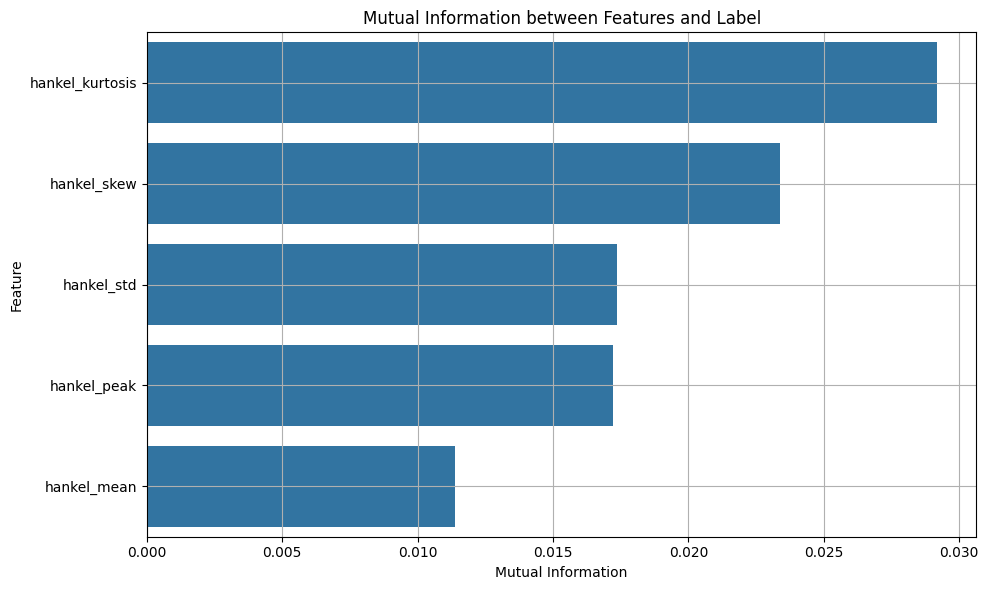

hankel_kurtosis    0.029181
hankel_skew        0.023371
hankel_std         0.017370
hankel_peak        0.017235
hankel_mean        0.011370
dtype: float64

In [26]:
positive_path = "../dataset/combined_extracted/positive.csv"
negative_path = "../dataset/combined_extracted/negative.csv"

positive_df = pd.read_csv(positive_path)
negative_df = pd.read_csv(negative_path)

positive_df['label'] = 1
negative_df['label'] = 0

combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

X = combined_df.drop(columns=["filename", "label"])
y = combined_df["label"]

mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information between Features and Label")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()

mi_series

#### Plotting graphs between each simplified feature

'../dataset/combined_extracted/f_200_sample'

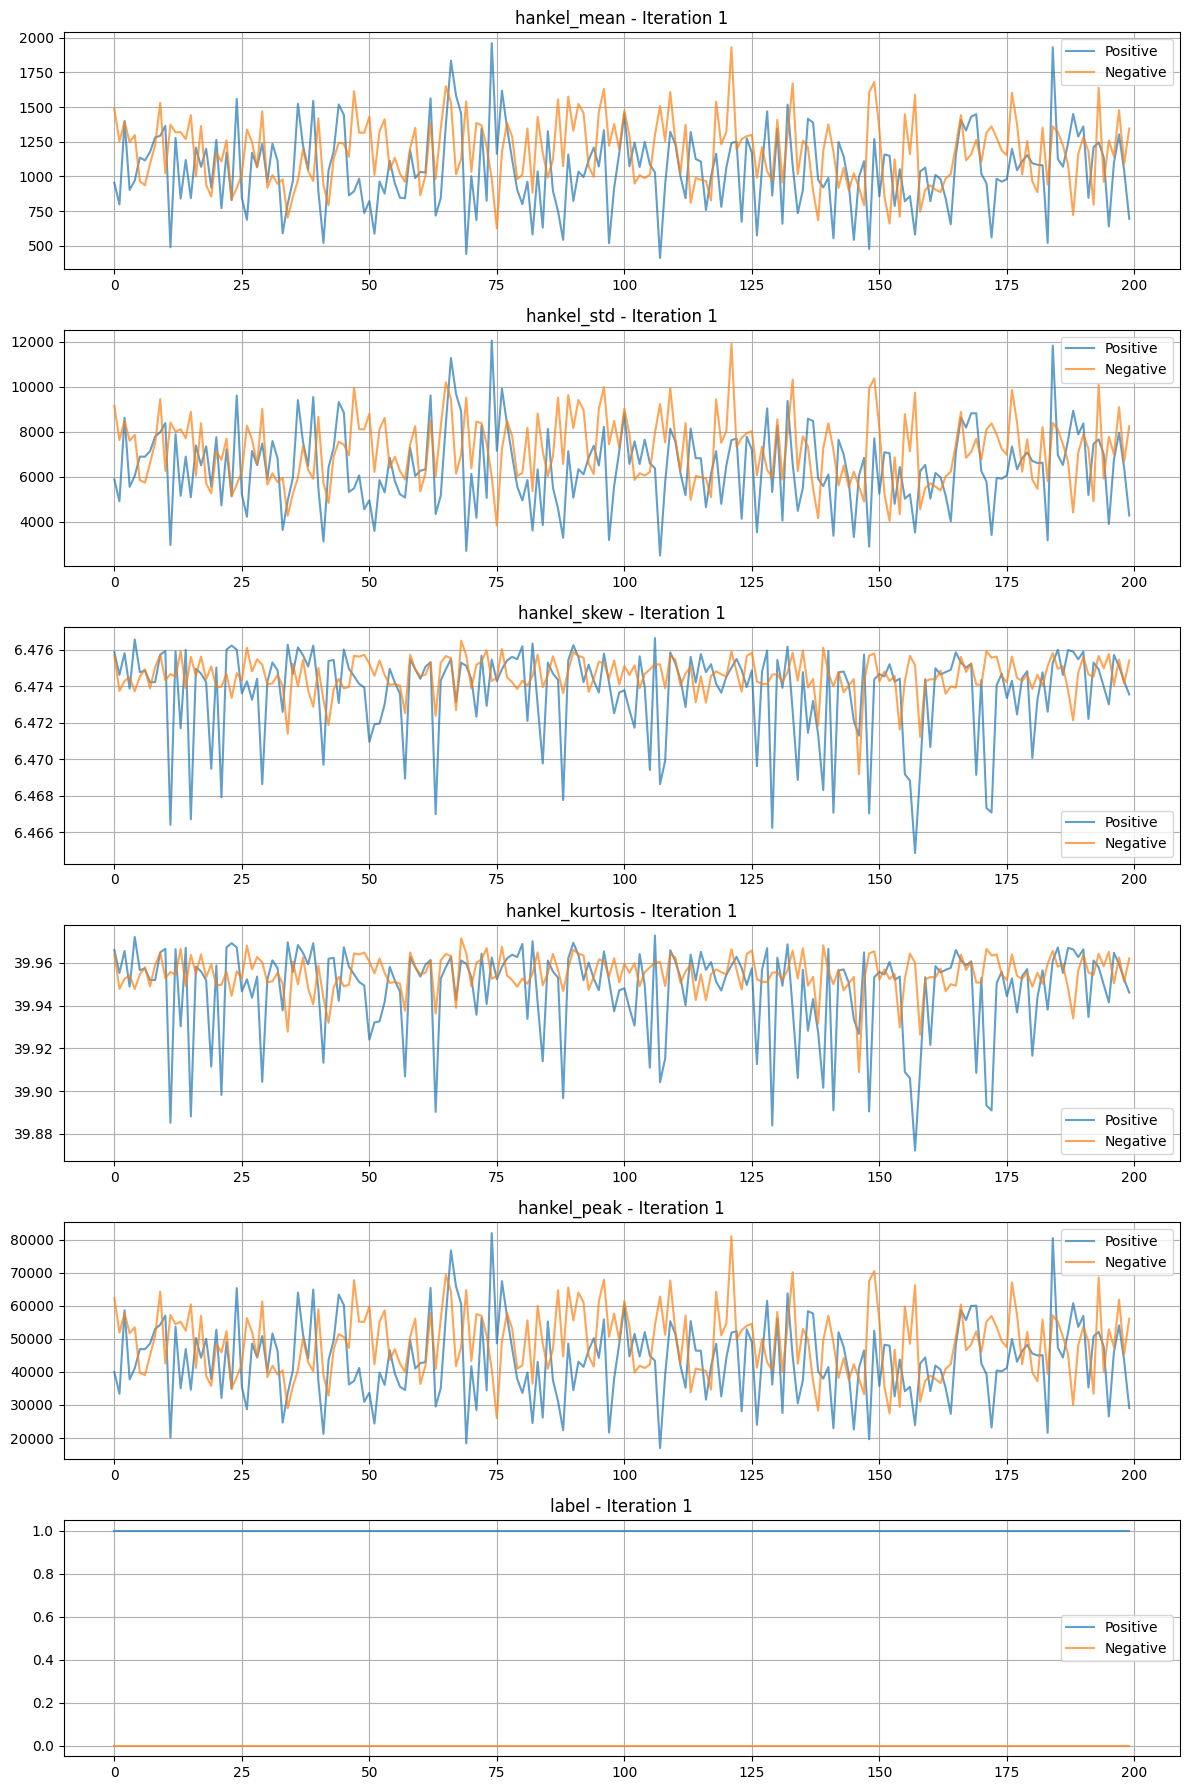

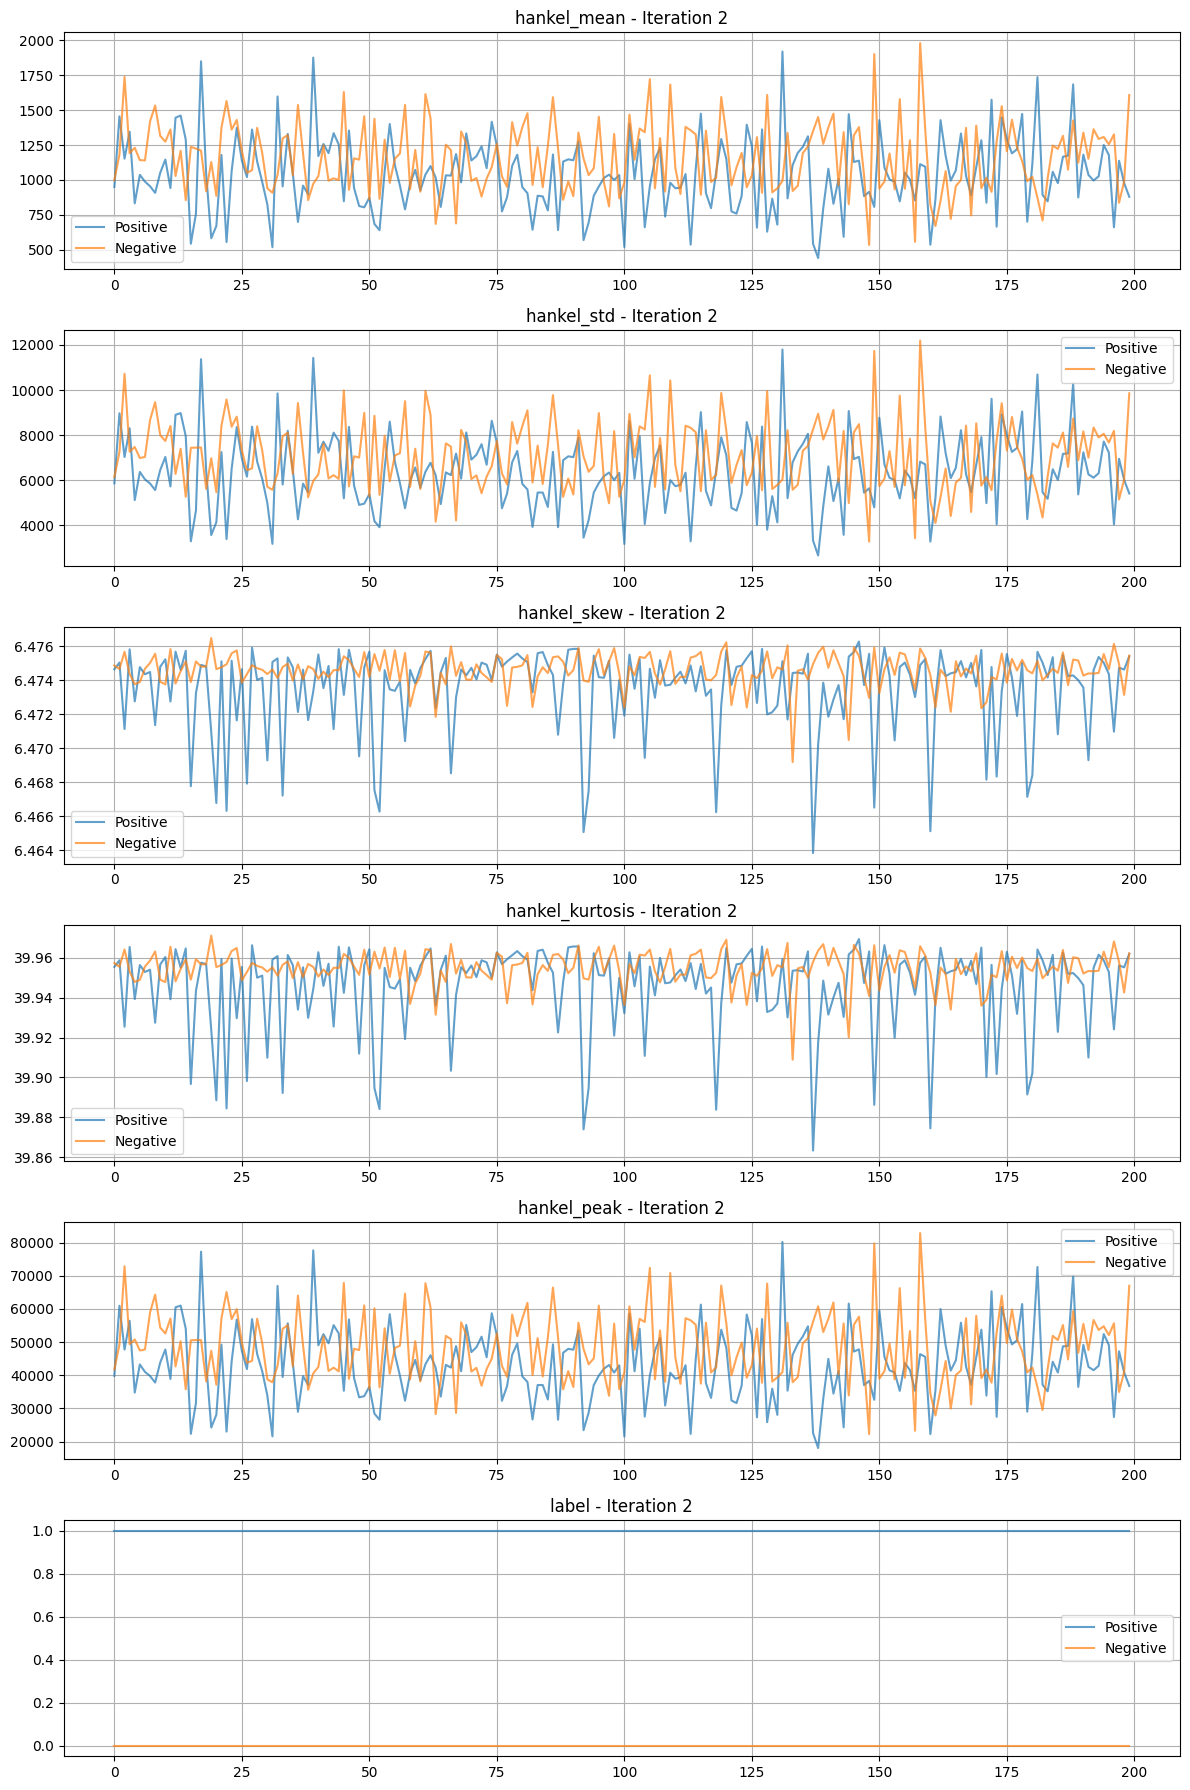

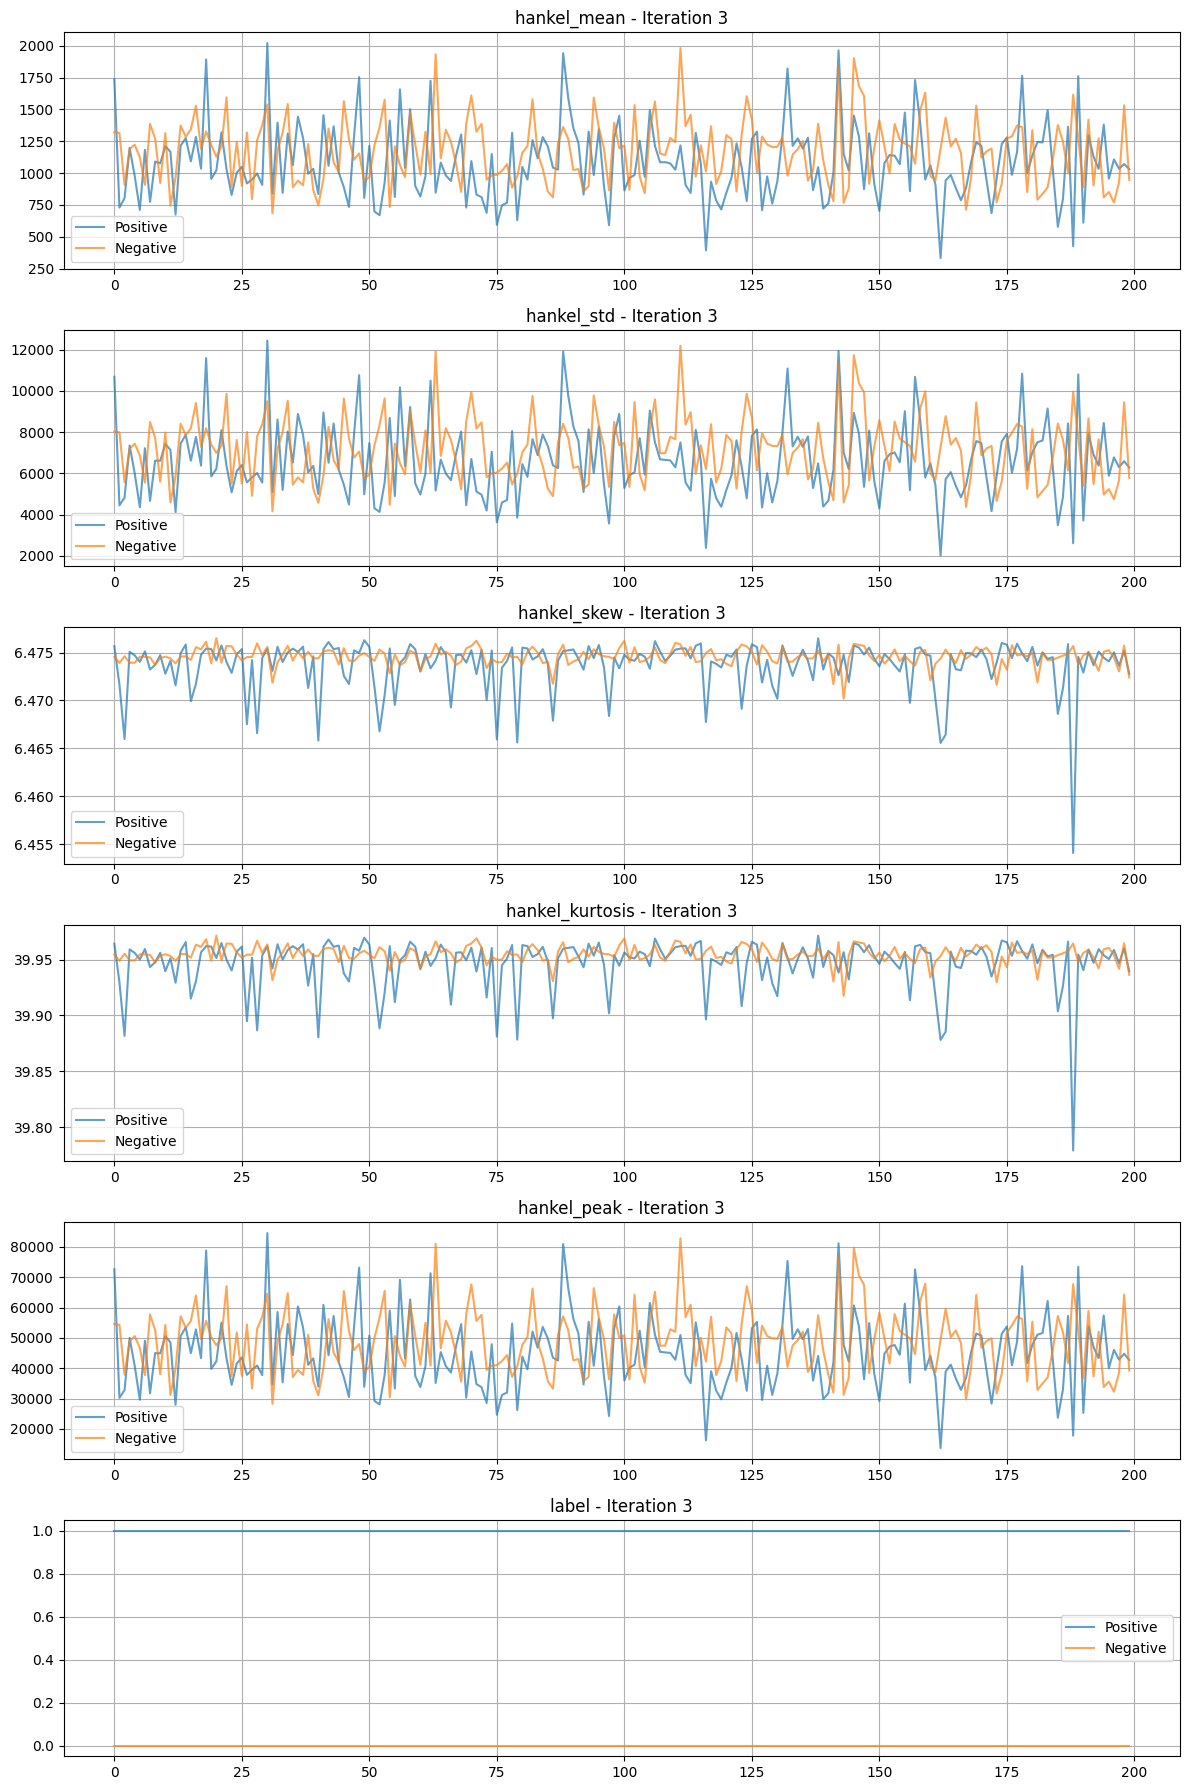

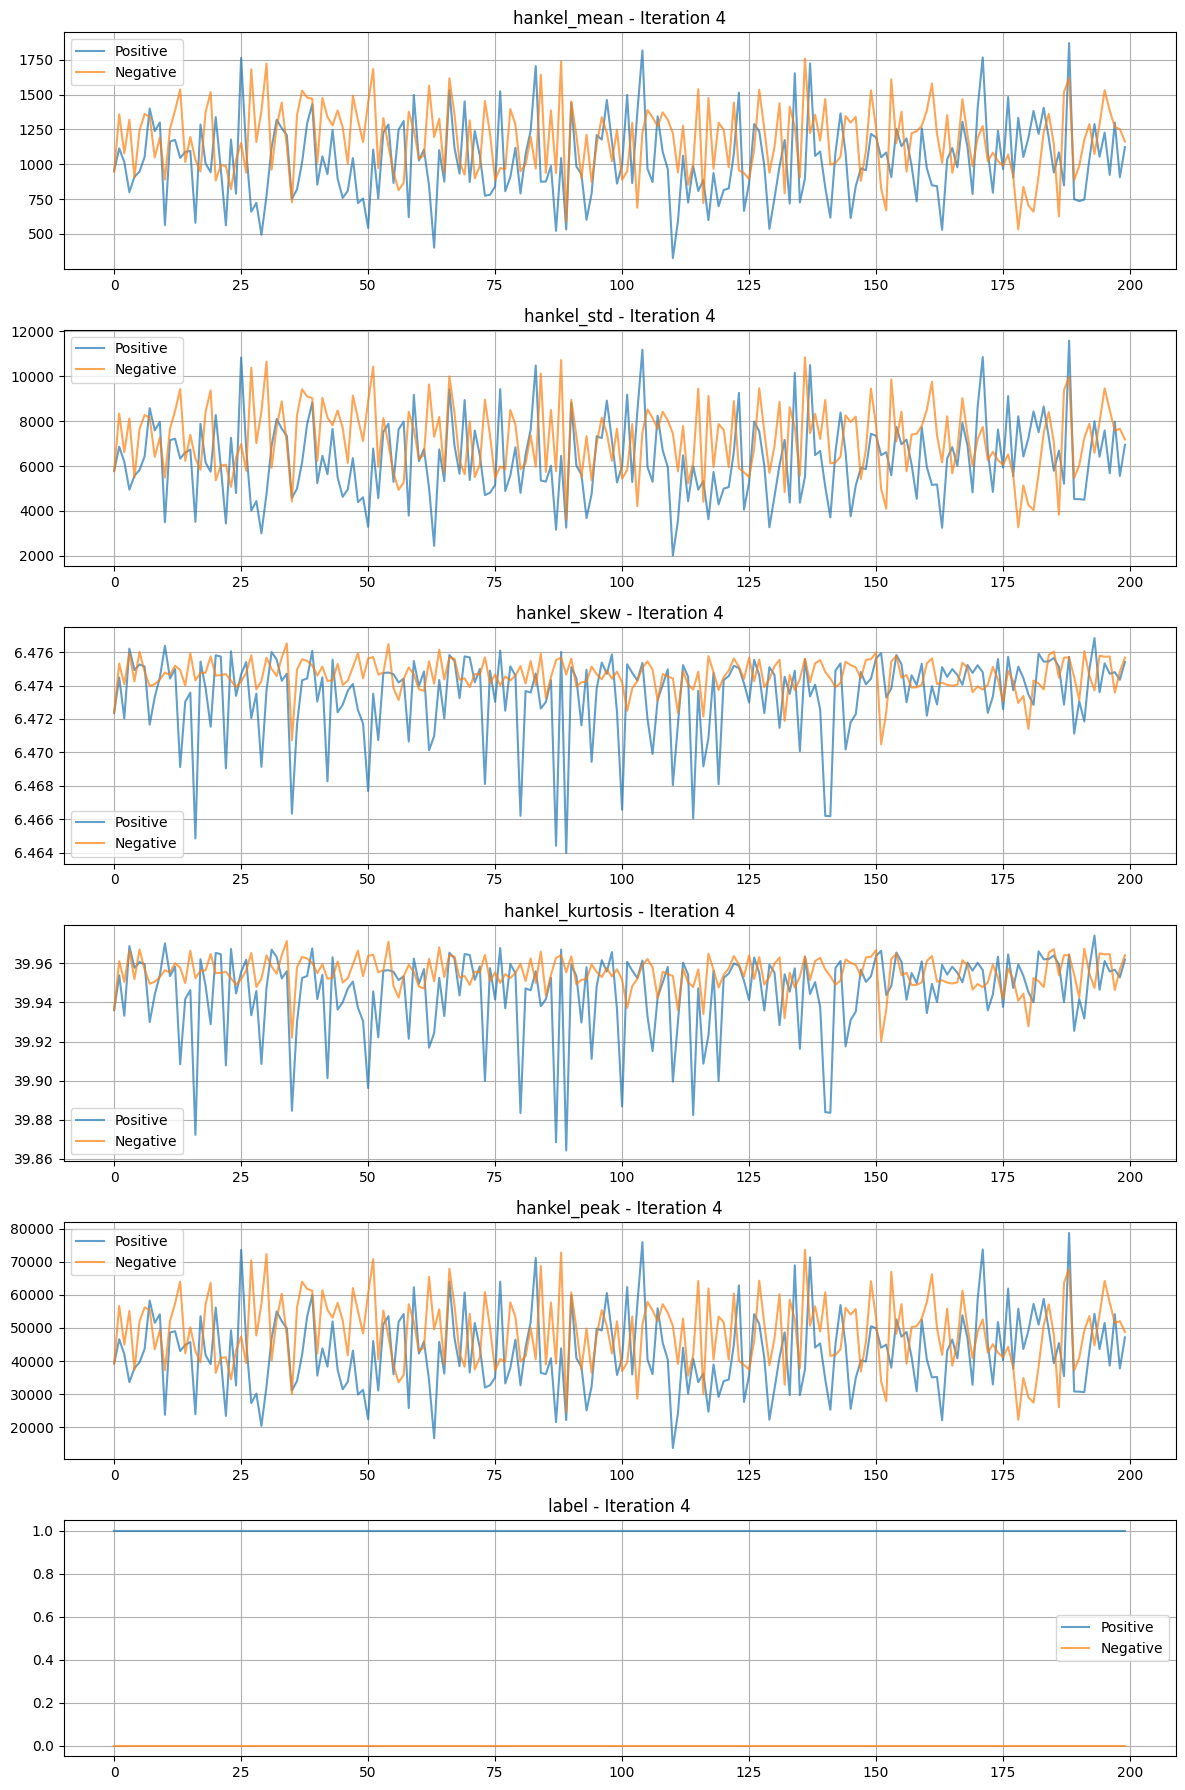

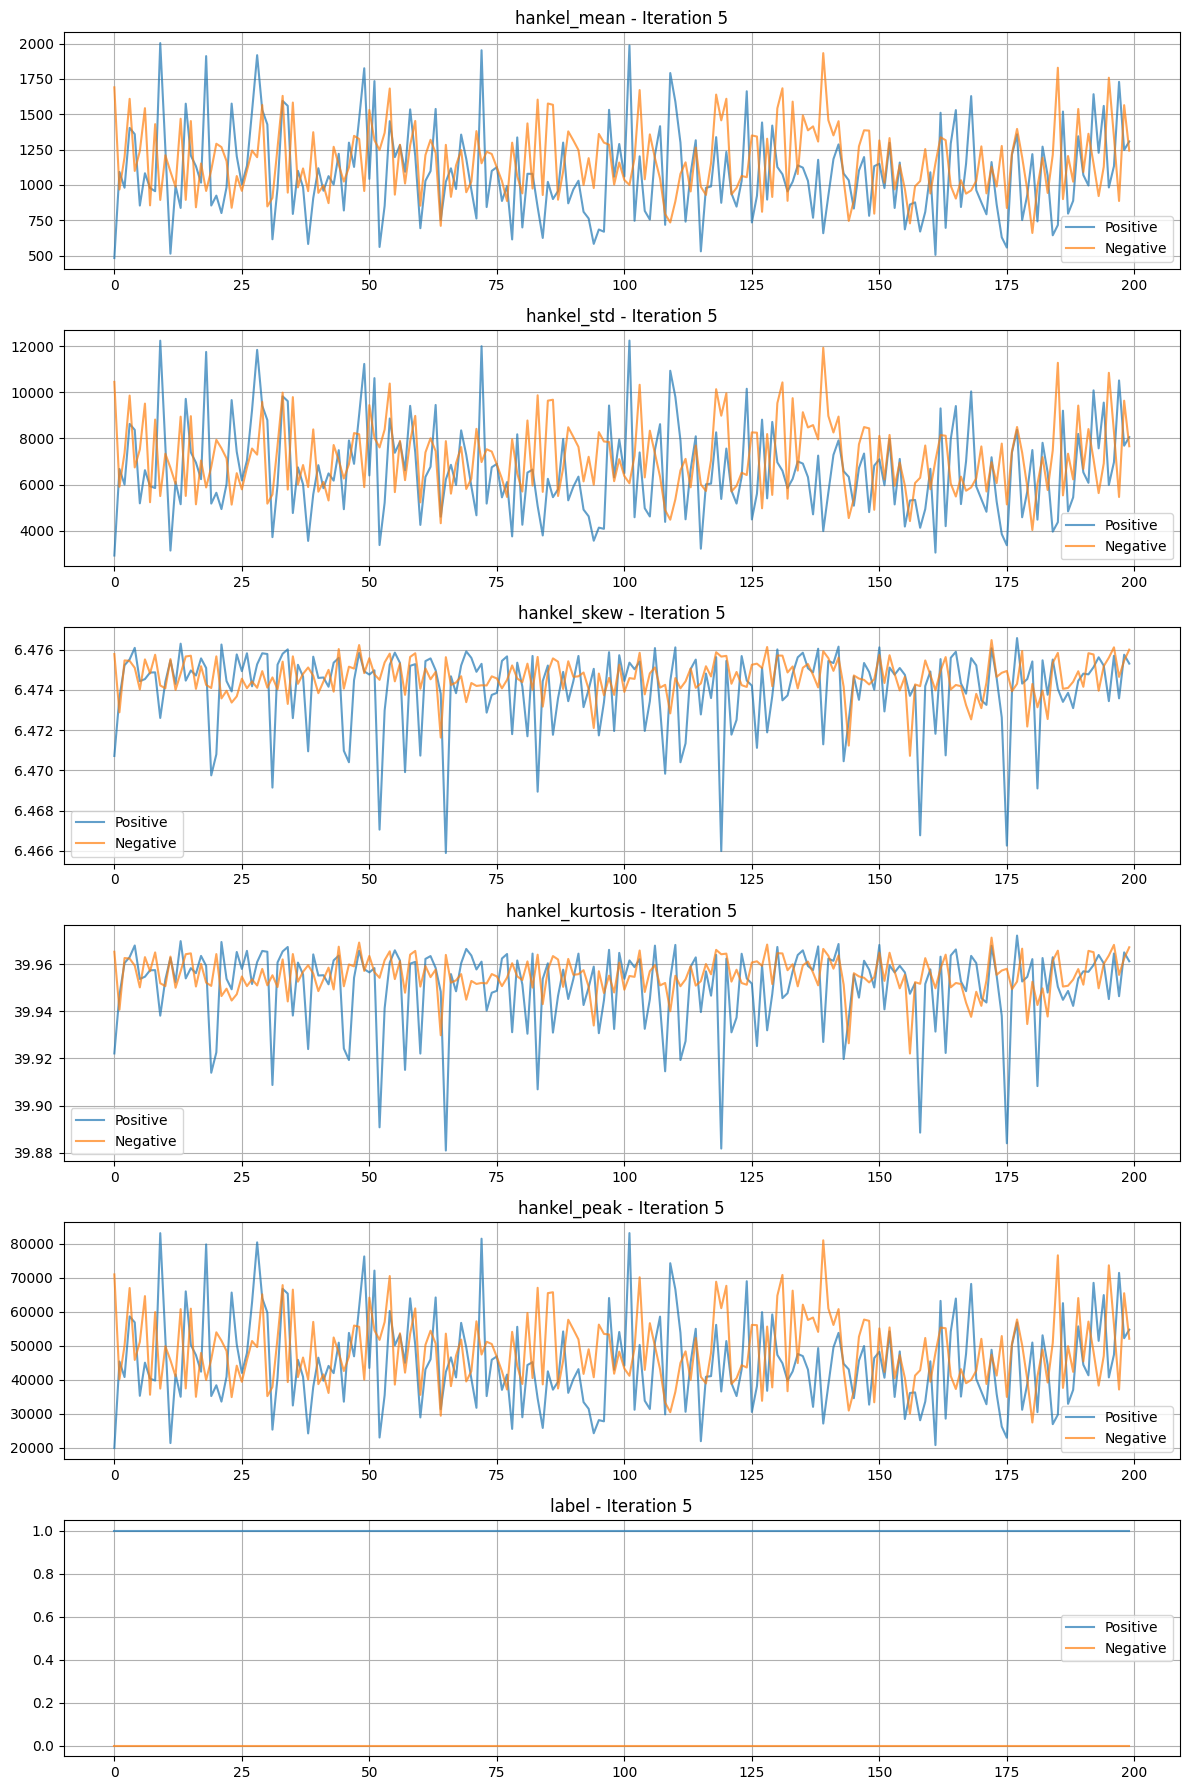

In [27]:
output_dir = "../dataset/combined_extracted/f_200_sample"
os.makedirs(output_dir, exist_ok=True)

positive_df = positive_df.drop(columns=["filename"])
negative_df = negative_df.drop(columns=["filename"])

repeats = 5
sample_size = 200

for iteration in range(1, repeats + 1):
    pos_sample = positive_df.sample(n=sample_size, random_state=iteration).reset_index(drop=True)
    neg_sample = negative_df.sample(n=sample_size, random_state=iteration).reset_index(drop=True)

    features = pos_sample.columns

    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 3 * len(features)))
    if len(features) == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        axes[i].plot(pos_sample[feature], label='Positive', alpha=0.7)
        axes[i].plot(neg_sample[feature], label='Negative', alpha=0.7)
        axes[i].set_title(f"{feature} - Iteration {iteration}")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    fig_path = os.path.join(output_dir, f"hankel_features_iteration_{iteration}.png")
    plt.savefig(fig_path)
    plt.close(fig_path)

output_dir

In [28]:
df = pd.read_csv("../dataset/combined_extracted/negative.csv")

correlation = df[["hankel_skew", "hankel_std"]].corr().iloc[0, 1]
correlation

np.float64(0.5768289422163728)

In [29]:
df = pd.read_csv("../dataset/combined_extracted/positive.csv")

correlation = df[["hankel_skew", "hankel_std"]].corr().iloc[0, 1]
correlation

np.float64(0.48212194250861323)

#### Adding the peak values of each feature in the images' feature files

In [32]:
def append_peak_values(folder_path):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

    for file in tqdm(files, desc=f"Appending peak values"):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        if df.empty or df.iloc[-1, 0] == "avg":
            data_df = df.iloc[:-1]
        else:
            data_df = df.copy()

        peak_values = data_df.iloc[:, 2:].max().values

        peak_row = ['peak', 'peak'] + list(peak_values)

        df.loc[len(df)] = peak_row

        df.to_csv(file_path, index=False)

base = "../dataset/extracted_feature/"
folder_list = ["positive", "negative"]
for folder in folder_list:
  append_peak_values(os.path.join(base, folder))

Appending peak values: 100%|██████████| 522/522 [00:01<00:00, 292.51it/s]


#### Collecting the peak values of each feature from the images' feature files

In [33]:
def collect_peak_features(folder_path, output_file):
  all_data = []

  files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
  for file in tqdm(files, desc=f"Processing {os.path.basename(folder_path)}"):
      file_path = os.path.join(folder_path, file)
      df = pd.read_csv(file_path)

      if not df.empty:
          last_row = df.iloc[-1]
          if str(last_row.iloc[0]).strip().lower() == 'peak':
              peak_row = last_row.copy()
              peak_row.iloc[0:2] = None  # Remove 'peak', 'peak'
              features = peak_row.dropna().astype(float).to_dict()
              features = {'filename': file, **features}
              all_data.append(features)

  final_df = pd.DataFrame(all_data)
  final_df.to_csv(output_file, index=False)
  print(f"Saved: {output_file}")
    
base = "../dataset/extracted_feature"
out = "../dataset/combined_extracted"
    
pos_folder = os.path.join(base, "positive")
neg_folder = os.path.join(base, "negative")
pos_output = os.path.join(out, "positive_peaks.csv")
neg_output = os.path.join(out, "negative_peaks.csv")

collect_peak_features(pos_folder, pos_output)
collect_peak_features(neg_folder, neg_output)

Processing positive: 100%|██████████| 3956/3956 [00:05<00:00, 684.97it/s]


Saved: ../dataset/combined_extracted\positive_peaks.csv


Processing negative: 100%|██████████| 522/522 [00:00<00:00, 659.72it/s]

Saved: ../dataset/combined_extracted\negative_peaks.csv


In [34]:
pos_df = pd.read_csv("../dataset/combined_extracted/positive_peaks.csv")
neg_df = pd.read_csv("../dataset/combined_extracted/negative_peaks.csv")

pos_df['label'] = 1
neg_df['label'] = 0

full_df = pd.concat([pos_df, neg_df], ignore_index=True)

features_df = full_df.drop(columns=[full_df.columns[0]])

correlation = features_df.corr(numeric_only=True)['label'].drop('label').sort_values(key=abs, ascending=False)

top_features = correlation.head(10)

top_features

hankel_mean       -0.092238
hankel_peak       -0.087881
hankel_std        -0.087802
hankel_skew        0.033260
hankel_kurtosis    0.033129
Name: label, dtype: float64

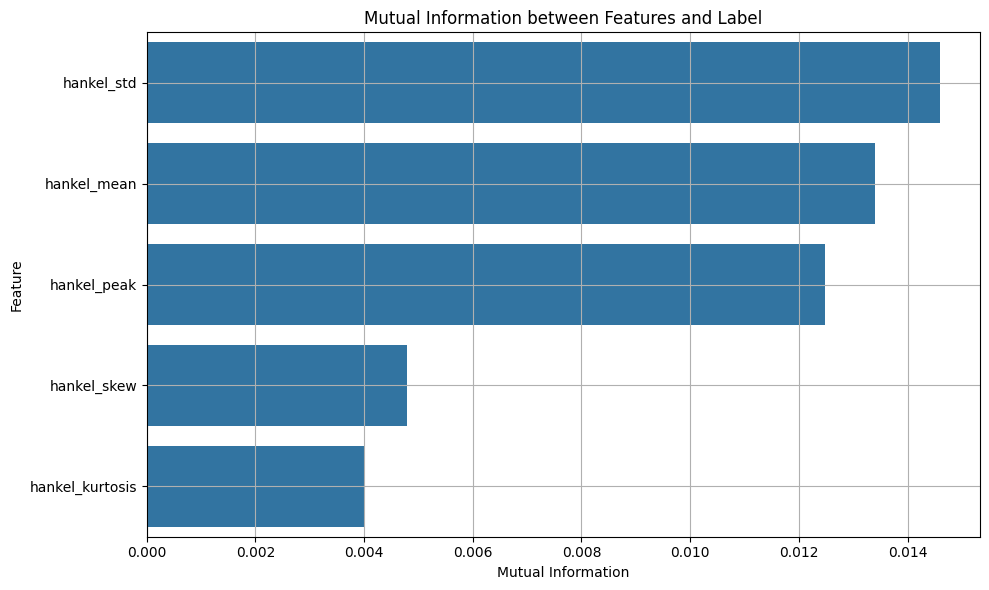

hankel_std         0.014604
hankel_mean        0.013395
hankel_peak        0.012476
hankel_skew        0.004796
hankel_kurtosis    0.003990
dtype: float64

In [35]:
combined_df = pd.concat([pos_df, neg_df], ignore_index=True)

X = combined_df.drop(columns=["filename", "label"])
y = combined_df["label"]

mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information between Features and Label")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()

mi_series

In [37]:
correlation1 = pos_df[["hankel_mean", "hankel_skew"]].corr().iloc[0, 1]
correlation2 = neg_df[["hankel_mean", "hankel_skew"]].corr().iloc[0, 1]

print(f"Positive: {correlation1}\nNegative: {correlation2}")

Positive: -0.11986779025058272
Negative: -0.20676951627787402


#### Ploting the peak values of each feature in between both classes

'../dataset/combined_extracted/f_peak_100_sample'

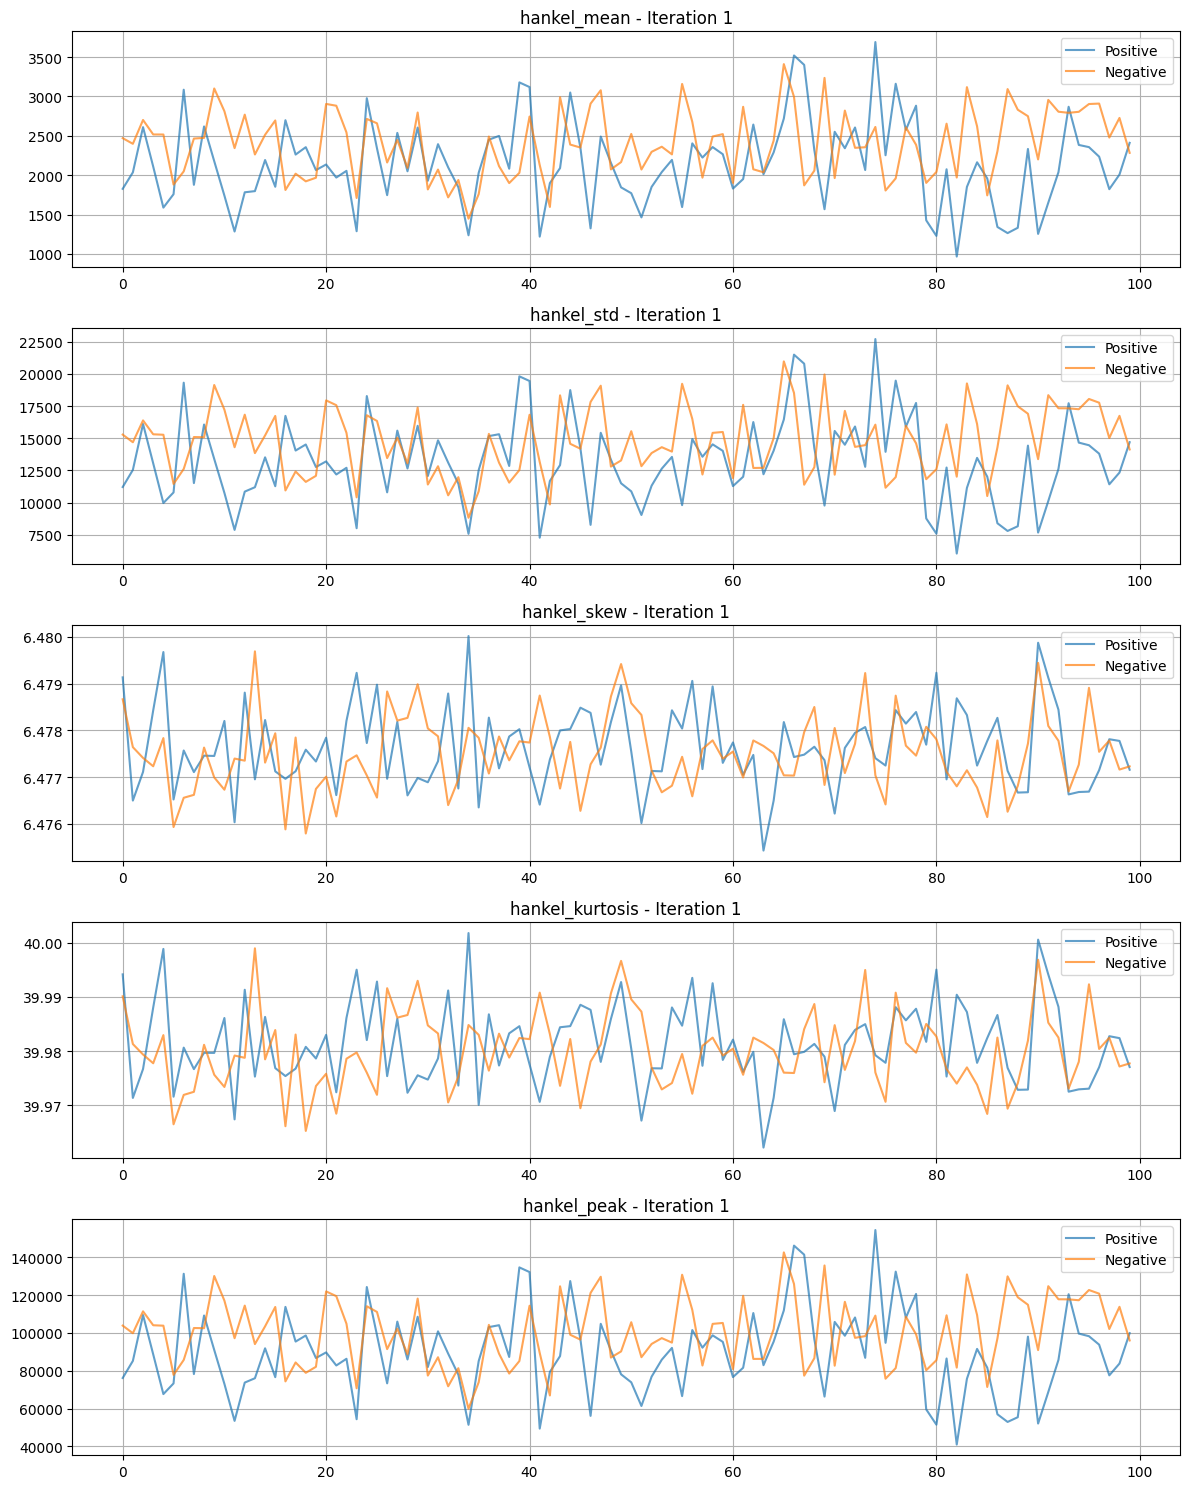

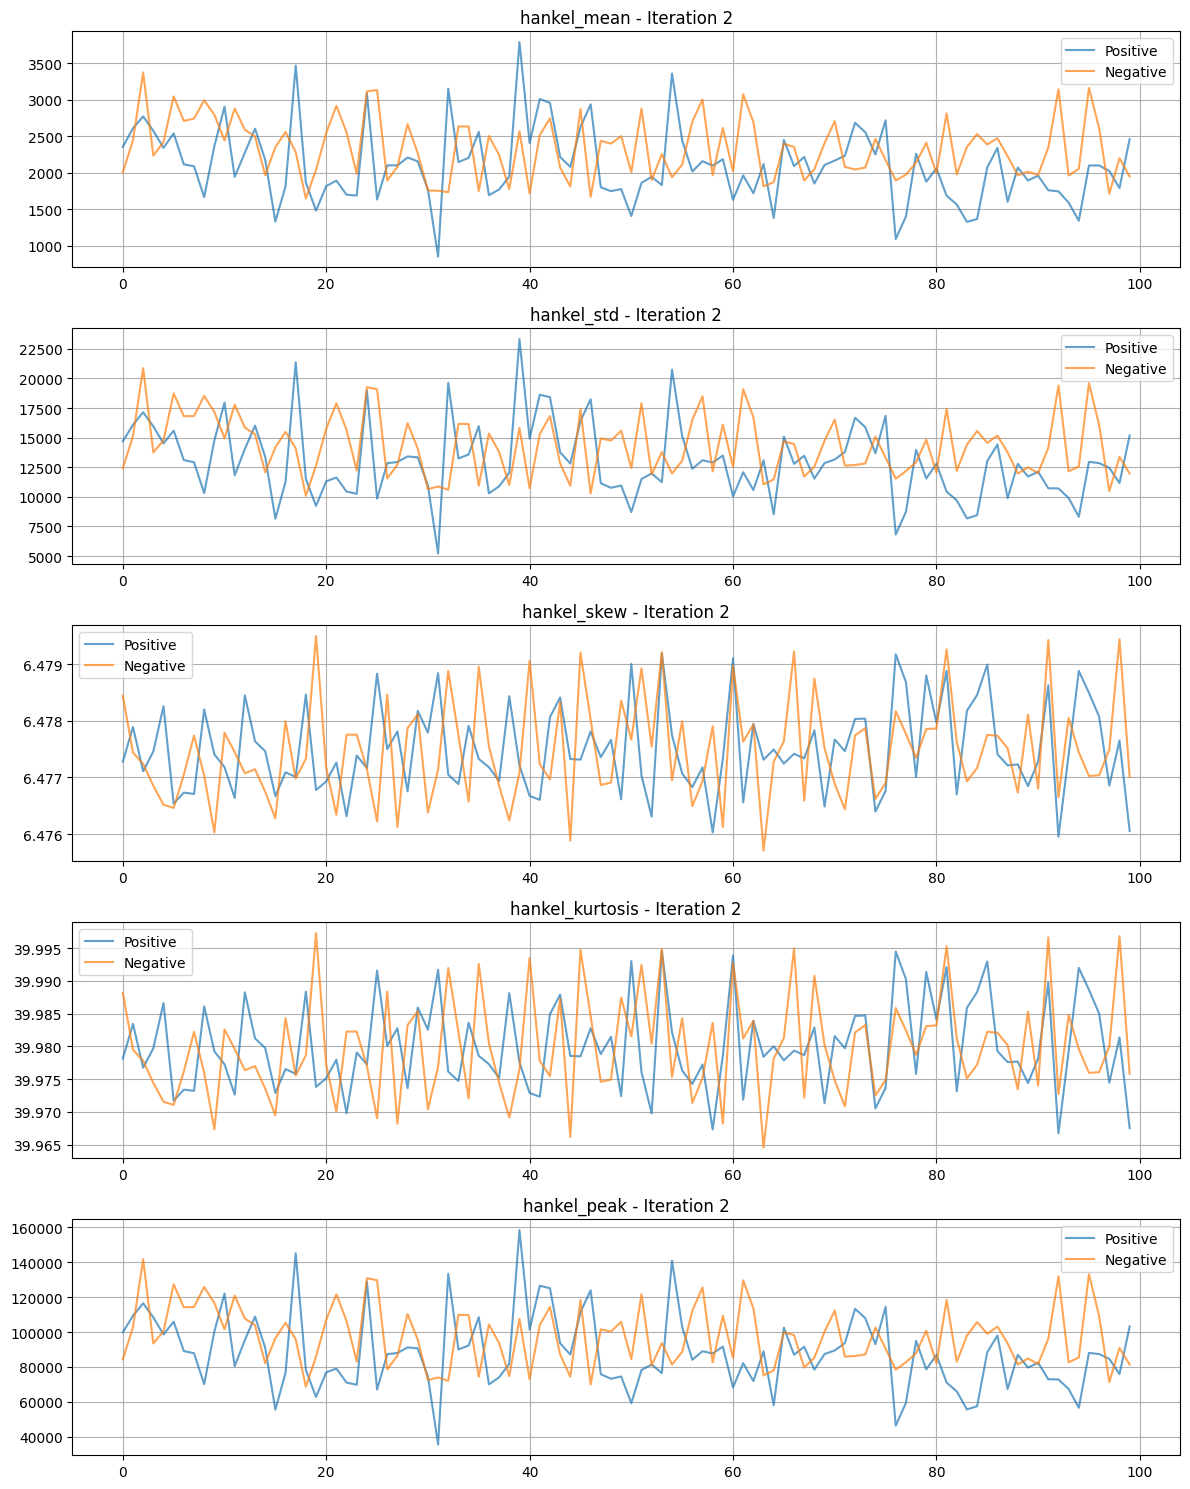

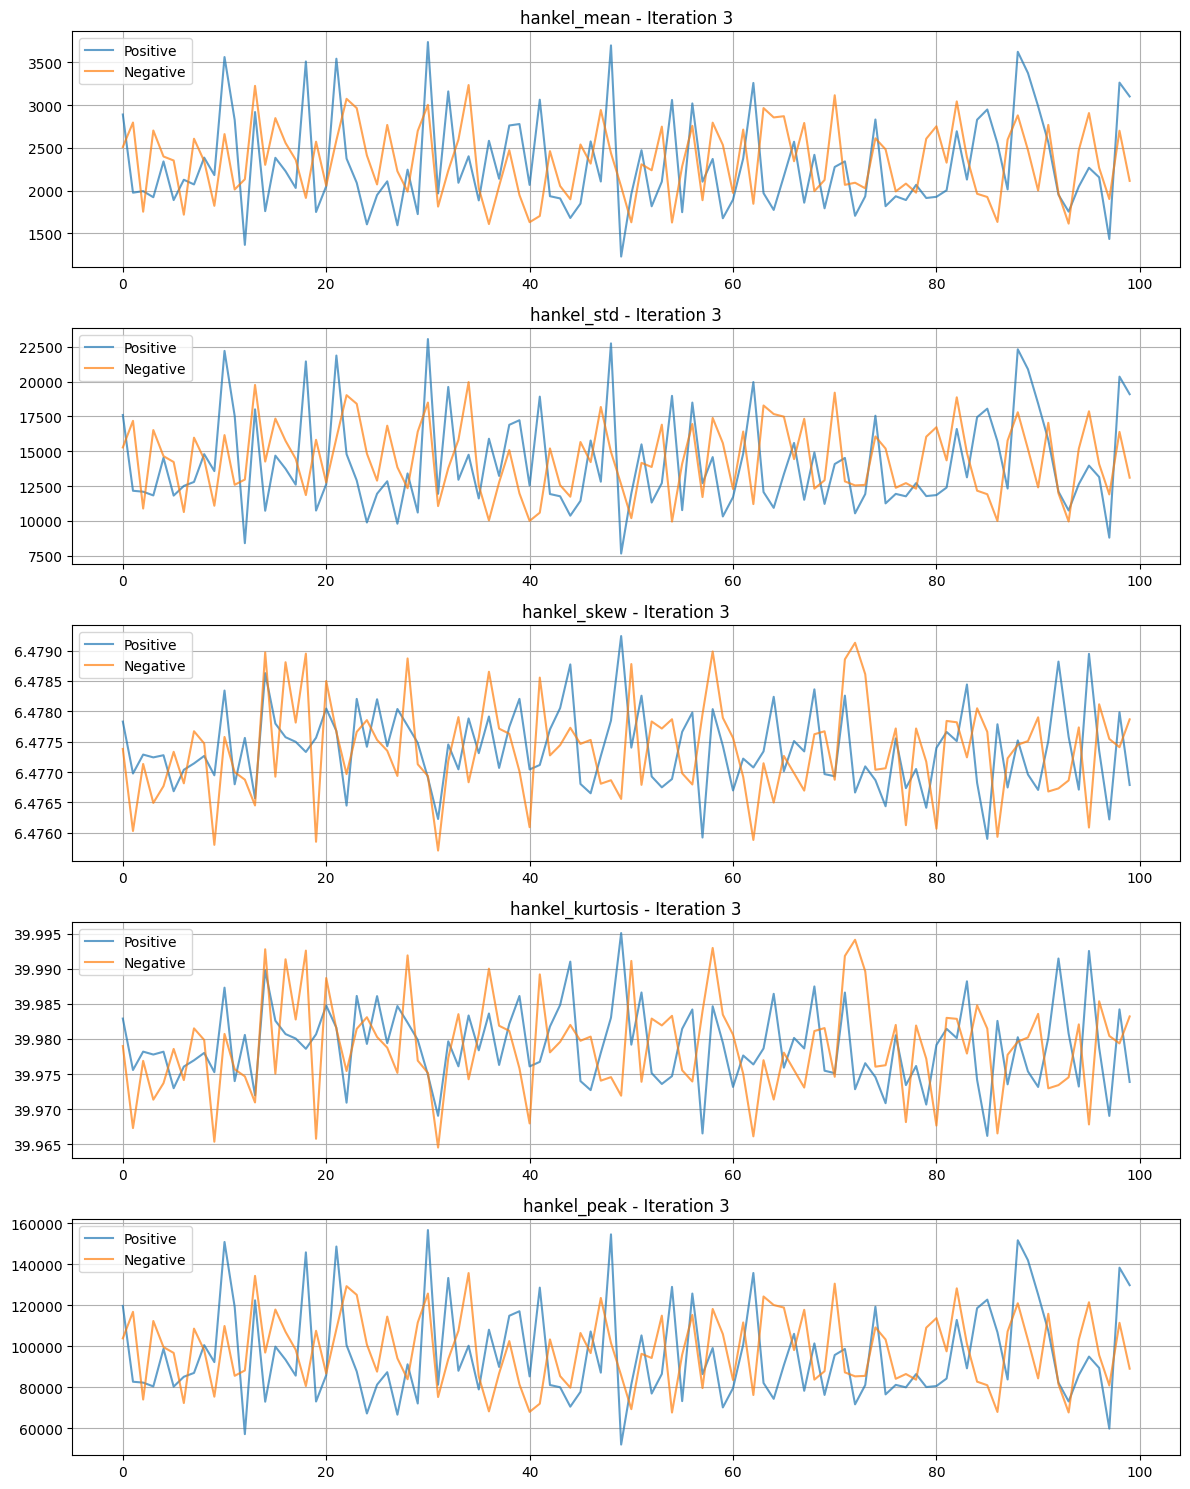

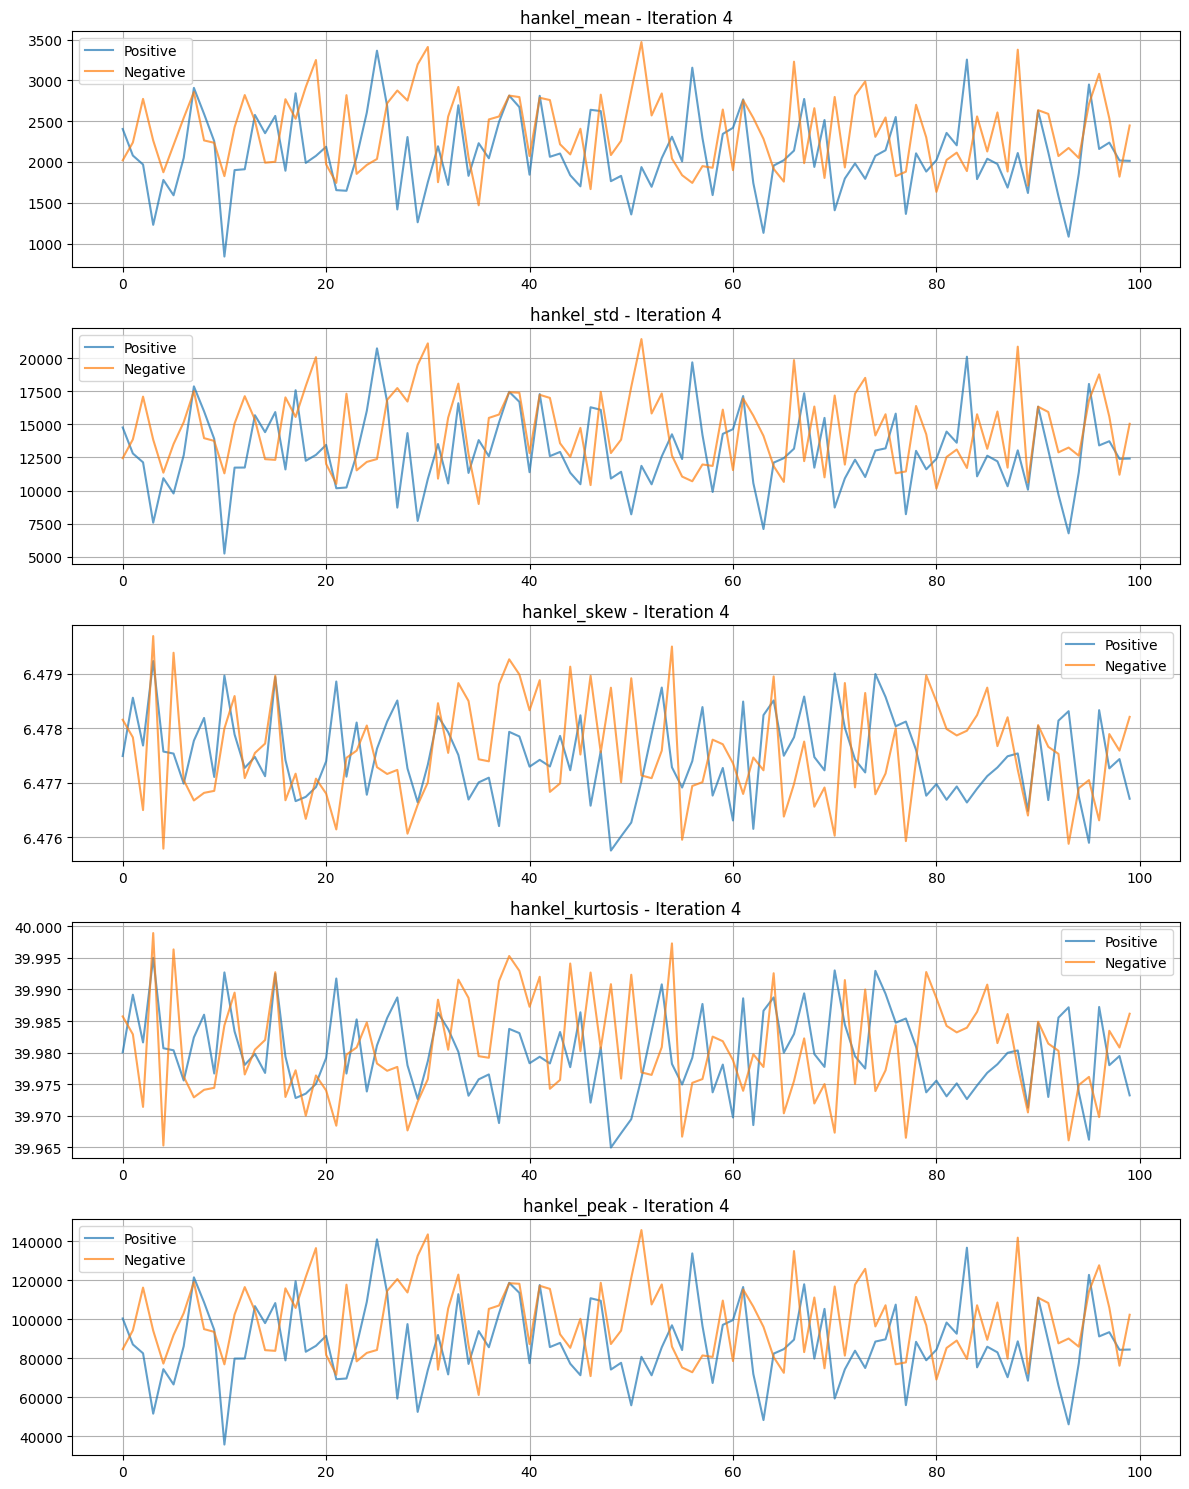

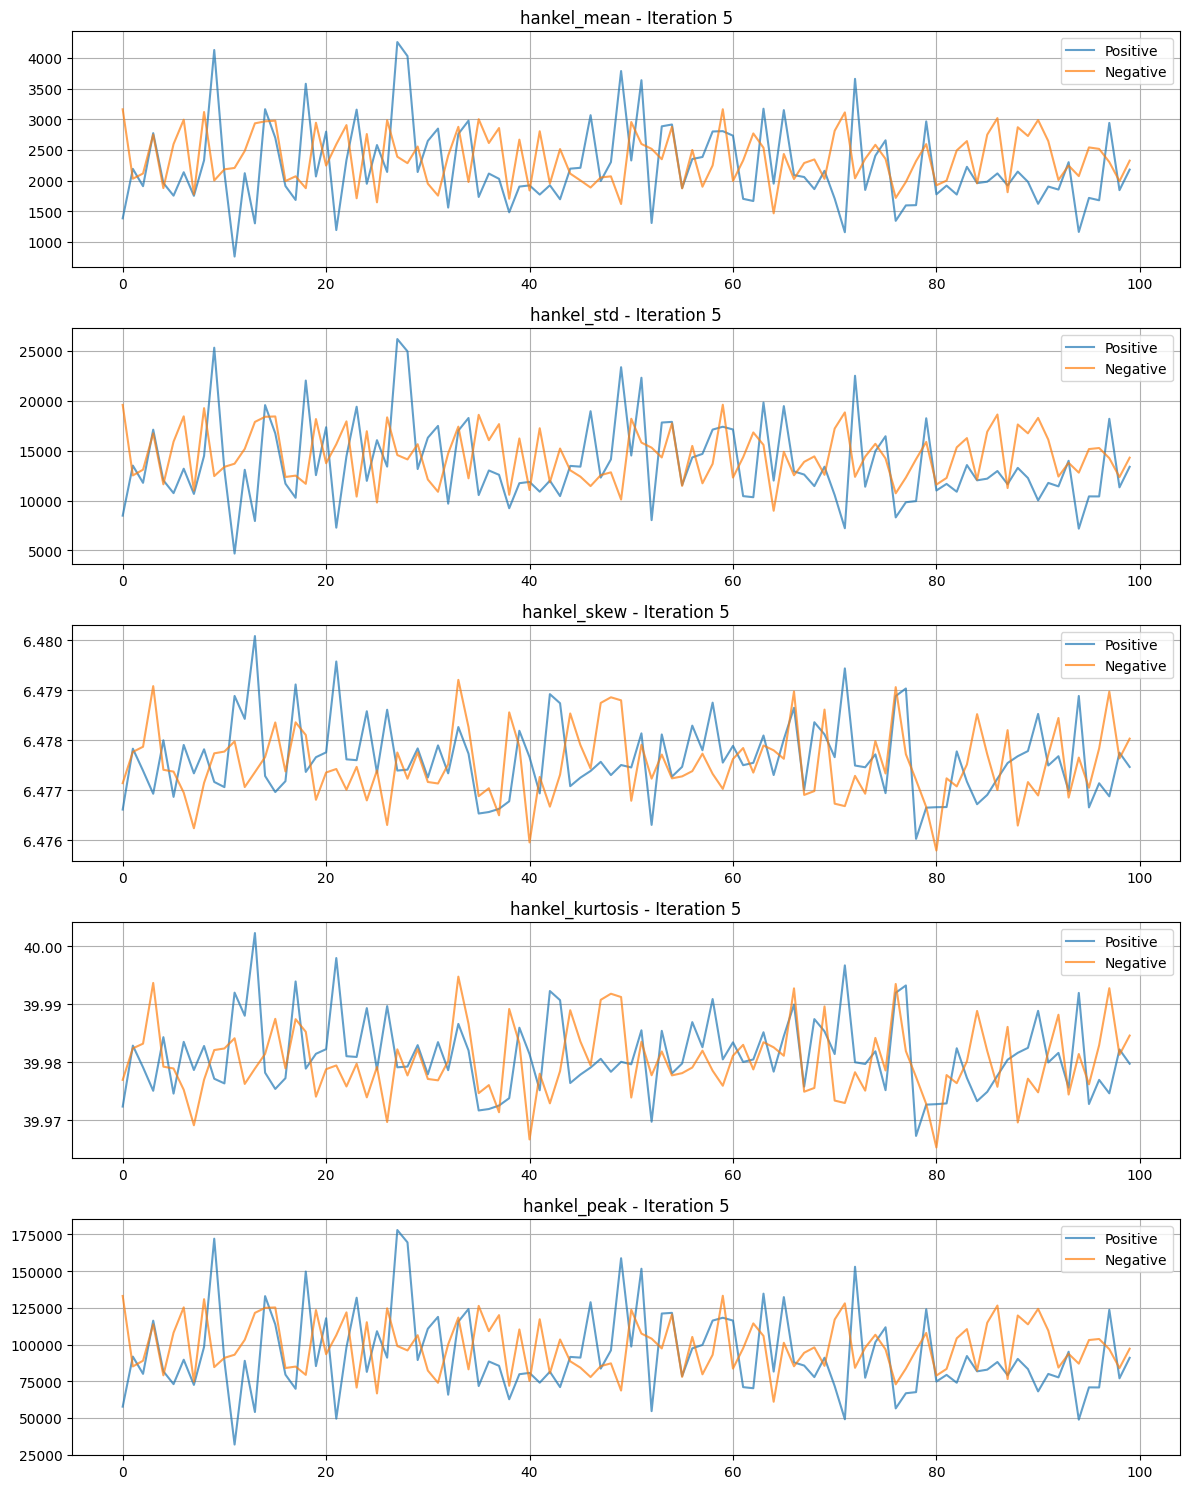

In [40]:
positive_df = pd.read_csv("../dataset/combined_extracted/positive_peaks.csv")
negative_df = pd.read_csv("../dataset/combined_extracted/negative_peaks.csv")

output_dir = "../dataset/combined_extracted/f_peak_100_sample"
os.makedirs(output_dir, exist_ok=True)

positive_df = positive_df.drop(columns=["filename"])
negative_df = negative_df.drop(columns=["filename"])

repeats = 5
sample_size = 100

for iteration in range(1, repeats + 1):
    pos_sample = positive_df.sample(n=sample_size, random_state=iteration).reset_index(drop=True)
    neg_sample = negative_df.sample(n=sample_size, random_state=iteration).reset_index(drop=True)

    features = pos_sample.columns

    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 3 * len(features)))
    if len(features) == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        axes[i].plot(pos_sample[feature], label='Positive', alpha=0.7)
        axes[i].plot(neg_sample[feature], label='Negative', alpha=0.7)
        axes[i].set_title(f"{feature} - Iteration {iteration}")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    fig_path = os.path.join(output_dir, f"hankel_features_iteration_{iteration}.png")
    plt.savefig(fig_path)
    plt.close(fig_path)

output_dir

#### Collecting the average and peak values of desired features, creating custom feature file

In [42]:
def collect_custom_features(folder_path, output_file):
    all_data = []

    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    for file in tqdm(files, desc=f"Processing {os.path.basename(folder_path)}"):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        if df.empty:
            continue

        avg_row = df.iloc[-2]
        peak_row = df.iloc[-1]

        if str(avg_row.iloc[0]).strip().lower() == 'avg' and str(peak_row.iloc[0]).strip().lower() == 'peak':
            avg_values = avg_row.drop(index=[df.columns[0], df.columns[1]])
            peak_values = peak_row.drop(index=[df.columns[0], df.columns[1]])

            result = {
                'filename': file,
                'hankel_mean': float(avg_values['hankel_mean']),
                'hankel_kurtosis': float(avg_values['hankel_kurtosis']),
                'hankel_std': float(peak_values['hankel_std']),
                'hankel_skew': float(peak_values['hankel_skew']),
                'hankel_peak': float(peak_values['hankel_peak']),
            }
            all_data.append(result)

    final_df = pd.DataFrame(all_data)
    final_df.to_csv(output_file, index=False)
    print(f"Saved: {output_file}")

base_folder = "../dataset/extracted_feature"
out = "../dataset/combined_extracted/custom_feature"
os.makedirs(out, exist_ok=True)

pos_folder = os.path.join(base_folder, "positive")
neg_folder = os.path.join(base_folder, "negative")

pos_output = os.path.join(out, "positive.csv")
neg_output = os.path.join(out, "negative.csv")

collect_custom_features(pos_folder, pos_output)
collect_custom_features(neg_folder, neg_output)

Processing positive: 100%|██████████| 3956/3956 [00:06<00:00, 585.45it/s]


Saved: ../dataset/combined_extracted/custom_feature\positive.csv


Processing negative: 100%|██████████| 522/522 [00:00<00:00, 581.39it/s]

Saved: ../dataset/combined_extracted/custom_feature\negative.csv


In [45]:
positive_df = pd.read_csv("../dataset/combined_extracted/custom_feature/positive.csv")
negative_df = pd.read_csv("../dataset/combined_extracted/custom_feature/negative.csv")

positive_df['label'] = 1
negative_df['label'] = 0

full_df = pd.concat([positive_df, negative_df], ignore_index=True)

features_df = full_df.drop(columns=[full_df.columns[0]])

correlation = features_df.corr(numeric_only=True)['label'].drop('label').sort_values(key=abs, ascending=False)

top_features = correlation.head(10)

top_features

hankel_kurtosis   -0.116461
hankel_mean       -0.114057
hankel_peak       -0.087881
hankel_std        -0.087802
hankel_skew        0.033260
Name: label, dtype: float64

In [46]:
correlation1 = positive_df[["hankel_skew", "hankel_mean"]].corr().iloc[0, 1]
correlation2 = negative_df[["hankel_skew", "hankel_mean"]].corr().iloc[0, 1]

print(f"Positive: {correlation1}\nNegative: {correlation2}")

Positive: 0.13098096995656008
Negative: 0.11565890710720628


In [47]:
df1 = pd.read_csv("../dataset/combined_extracted/custom_feature/positive.csv")
df2 = pd.read_csv("../dataset/combined_extracted/custom_feature/negative.csv")

min_len = min(len(df1), len(df2))
df1 = df1.iloc[:min_len].reset_index(drop=True)
df2 = df2.iloc[:min_len].reset_index(drop=True)

correlation1 = df1["hankel_peak"].corr(df2["hankel_mean"])
correlation2 = df2["hankel_peak"].corr(df1["hankel_mean"])

print(f"df1.hankel_peak vs df2.hankel_mean: {correlation1}")
print(f"df2.hankel_peak vs df1.hankel_mean: {correlation2}")

df1.hankel_peak vs df2.hankel_mean: -0.05084863695786805
df2.hankel_peak vs df1.hankel_mean: -0.050716801384579915


In [48]:
df1 = pd.read_csv("../dataset/combined_extracted/custom_feature/positive.csv")
df2 = pd.read_csv("../dataset/combined_extracted/custom_feature/negative.csv")

df1_sampled = df1.sample(n=350, random_state=42).reset_index(drop=True)
df2_sampled = df2.sample(n=350, random_state=42).reset_index(drop=True)

correlation1 = df1_sampled["hankel_std"].corr(df2_sampled["hankel_mean"])
correlation2 = df2_sampled["hankel_std"].corr(df1_sampled["hankel_mean"])

print(f"positive_set.std vs negative_set.mean: {correlation1}")
print(f"negative_set.std vs positive_set.mean: {correlation2}")

correlation1 = df1_sampled["hankel_std"].corr(df1_sampled["hankel_mean"])
correlation2 = df2_sampled["hankel_std"].corr(df2_sampled["hankel_mean"])

print(f"positive_set.std vs positive_set.mean: {correlation1}")
print(f"negative_set.std vs negative_set.mean: {correlation2}")

positive_set.std vs negative_set.mean: -0.03638943818721173
negative_set.std vs positive_set.mean: -0.10079762014959247
positive_set.std vs positive_set.mean: 0.739074738322972
negative_set.std vs negative_set.mean: 0.715205583730991
